# Segmentation and Classification of Mammographic Images

In [1]:
# Daniel Vitor de Oliveira Santos, 716417, Ciência da Computação Coração Eucarístico
# Guilherme Cosso Lima Pimenta, gclpimenta@sga.pucminas.br, Ciência da Computação Coração Eucarístico
# Larissa Kaweski Siqueira, larissa.kaweski@sga.pucminas.br, Ciência da Computação Coração Eucarístico
# Imports
import pandas as pd
import numpy as np
import cv2
from pathlib import Path
import os.path
from fastai.vision.all import *
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
from time import time

c:\Users\criss\AppData\Local\Programs\Python\Python37\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Benchmark CPU x GPU

In [18]:
# Create default model to test
def conv_model(device, filters, kz):
    with tf.device(device):
        model = Sequential()
        model.add(Conv2D(filters, kernel_size=3, padding='same', activation='relu', input_shape=(28, 28, 1)))
        model.add(MaxPool2D(pool_size=2))
        model.add(Conv2D(filters, kernel_size=3, padding='same', activation='relu'))
        model.add(MaxPool2D(pool_size=2))
        model.add(Conv2D(filters, kernel_size=3, padding='same', activation='relu'))
        model.add(MaxPool2D(pool_size=2))
        model.add(Flatten())
        model.add(Dense(10, activation='softmax'))

        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
        model.summary()

        return model

# Run model and compute time
def run(model, x_train, y_train, epochs=128, batch_size=32):
    start = time()
    model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size)
    end = time()

    return end - start

# Load dataset mnist
(x_train, y_train), (_, _) = mnist.load_data()

# Preprocessing data
x_train = x_train / 255.0 # Normalize
x_train = x_train.reshape(-1, 28, 28, 1) # Add the channel axis
y_train = to_categorical(y_train, num_classes=10) # Convert to one-hot encoding

# Define CPU and GPU models
cpu_model = conv_model('CPU', 64, 3)
gpu_model = conv_model('DML', 64, 3)

# Default hiperparams
epochs = 8
bz = 64

# Run models
conv_cpu_time = run(cpu_model, x_train, y_train, epochs=epochs, batch_size=bz)
conv_gpu_time = run(gpu_model, x_train, y_train, epochs=epochs, batch_size=bz)

# Computation time
print("Time to train with CPU:", conv_cpu_time)
print("Time to train with GPU:", conv_gpu_time)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 7, 7, 64)          36928     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 3, 3, 64)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 576)              

# Auxiliary Functions

In [4]:
# Get all data from a directory and return as a dataframe
def get_dataset(folder_path):
    folder = Path(folder_path)

    filepaths = list(folder.glob(r'**/*.png'))
    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    return pd.concat([filepaths, labels], axis=1)

# Check if is multiple of 4
def is_multiple_of_4(number):
    number = number.split("(")[-1].split(")")[0]
    number = number.strip()
    return int(number) % 4 == 0

# Split dataframe into train and validation
def split_train_and_validation(dataset):
    images_train = dataset[~dataset['Filepath'].apply(is_multiple_of_4)]
    images_validation = dataset[dataset['Filepath'].apply(is_multiple_of_4)]

    print("Training set:")
    print("Quantity of samples:", len(images_train))
    print("Quantity of classes:", len(images_train['Label'].unique()))
    print()

    print("Validation set:")
    print("Quantity of samples:", len(images_validation))
    print("Quantity of classes:", len(images_validation['Label'].unique()))
    
    return images_train, images_validation

# Map labels based on initial
def map_label(label):
    if label.startswith('D'):
        return 'I'
    elif label.startswith('E'):
        return 'II'
    elif label.startswith('F'):
        return 'III'
    elif label.startswith('G'):
        return 'IV'
    else:
        return label
    
# Crop the image
def crop_image(image):
    # Get the dimensions of the image
    height, width = image.shape[:2]

    # Define the coordinates of the region of interest (ROI)
    x = 15
    y = 15
    crop_width = width - 30
    crop_height = height - 30
    
    return image[y:y+crop_height, x:x+crop_width]

# Find the optimal gamma for the image
def find_optimal_gamma(image):
    # Calculate average of pixels
    mean = np.mean(image)

    # Return the optimal gamma number for this image
    return np.log(mean) / np.log(512)

# Identify the largest object in the image
def biggest_object(image):
    # Perform labeling of connected components
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(image)

    # Find the index of the largest object (excluding the background)
    largest_label = np.argmax(stats[1:, cv2.CC_STAT_AREA]) + 1

    # Create a mask only for the largest object
    return np.uint8(labels == largest_label) * 255

# Segment a image
def segment_image(image):
    # Crop image, removing 15 pixels from the edges
    cropped = crop_image(image)
    
    # Set the ideal gamma
    gamma = find_optimal_gamma(image)
    
    # Apply gamma and Otsu transformation if necessary, otherwise apply only Threhold Binary
    if gamma >= 0.6:
        gamma_corrected = np.power(cropped / 255.0, gamma)
        image_filtered = np.uint8(gamma_corrected * 255)
        _, result = cv2.threshold(image_filtered, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    else:
        image_filtered = cropped
        _, result = cv2.threshold(image_filtered, 1, maxval=255, type=cv2.THRESH_BINARY)
        
    # Largest object in the image (breast)
    image_biggest = biggest_object(result)
    
    # Match the mask of the largest object with the original cropped image
    return cv2.bitwise_and(cropped, cropped, mask=image_biggest)

# Function to display images
def display_variations(filepaths):
    fig, axs = plt.subplots(1, 4, figsize=(15, 5))  # Create a figure with one row and four columns

    titles = ["Original Segmented", "Flipped", "Equalized", "Flipped Equalized"]

    for i, filepath in enumerate(filepaths):
        image = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
        axs[i].imshow(image, cmap='gray')
        axs[i].set_title(titles[i])  # Set the title based on the titles list
        
    plt.tight_layout()
    plt.show()

# Load Images into Dataframe

In [6]:
# Read images from directory
folder_path = './images/'
dataset = get_dataset(folder_path)
dataset

,Filepath,Label
0,images\DleftCC\d_left_cc (1).png,DleftCC
1,images\DleftCC\d_left_cc (10).png,DleftCC
2,images\DleftCC\d_left_cc (100).png,DleftCC
3,images\DleftCC\d_left_cc (101).png,DleftCC
4,images\DleftCC\d_left_cc (102).png,DleftCC
...,...,...
5019,images\GrightMLO\g_right_mlo (95).png,GrightMLO
5020,images\GrightMLO\g_right_mlo (96).png,GrightMLO
5021,images\GrightMLO\g_right_mlo (97).png,GrightMLO
5022,images\GrightMLO\g_right_mlo (98).png,GrightMLO


# Change Label

In [7]:
# Apply the function to the values ​​of "Label"
dataset['Label'] = dataset['Label'].apply(map_label)
dataset

,Filepath,Label
0,images\DleftCC\d_left_cc (1).png,I
1,images\DleftCC\d_left_cc (10).png,I
2,images\DleftCC\d_left_cc (100).png,I
3,images\DleftCC\d_left_cc (101).png,I
4,images\DleftCC\d_left_cc (102).png,I
...,...,...
5019,images\GrightMLO\g_right_mlo (95).png,IV
5020,images\GrightMLO\g_right_mlo (96).png,IV
5021,images\GrightMLO\g_right_mlo (97).png,IV
5022,images\GrightMLO\g_right_mlo (98).png,IV


In [8]:
# Disinct labels and count
dataset['Label'].value_counts()

I      1256
II     1256
III    1256
IV     1256
Name: Label, dtype: int64

# Split Train and Validation

In [9]:
# Split dataset
train, test = split_train_and_validation(dataset)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

Training set:
Quantity of samples: 3776
Quantity of classes: 4

Validation set:
Quantity of samples: 1248
Quantity of classes: 4


# Transform into 2 Classes

In [10]:
# Definir o dicionário de mapeamento para os labels
label_mapping = {'I': 'I', 'II': 'I', 'III': 'III', 'IV': 'III'}

# Substituir os valores dos labels
train['Label'] = train['Label'].map(label_mapping)
train['Label'].value_counts()

I      1888
III    1888
Name: Label, dtype: int64

In [11]:
train = train.sample(frac=1).reset_index(drop=True)
train

,Filepath,Label
0,images\FleftMLO\f_left_mlo (302).png,III
1,images\DleftCC\d_left_cc (191).png,I
2,images\FrightMLO\f_right_mlo (26).png,III
3,images\GleftCC\g_left_cc (251).png,III
4,images\DrightMLO\d_right_mlo (10).png,I
...,...,...
3771,images\ErightCC\e_right_cc (158).png,I
3772,images\DrightMLO\d_right_mlo (115).png,I
3773,images\FrightMLO\f_right_mlo (143).png,III
3774,images\GrightMLO\g_right_mlo (135).png,III


In [12]:
# Definir o dicionário de mapeamento para os labels
label_mapping = {'I': 'I', 'II': 'I', 'III': 'III', 'IV': 'III'}

# Substituir os valores dos labels
test['Label'] = test['Label'].map(label_mapping)
test['Label'].value_counts()

I      624
III    624
Name: Label, dtype: int64

In [13]:
test = test.sample(frac=1).reset_index(drop=True)
test

,Filepath,Label
0,images\FrightMLO\f_right_mlo (48).png,III
1,images\ErightCC\e_right_cc (240).png,I
2,images\DrightMLO\d_right_mlo (68).png,I
3,images\DleftMLO\d_left_mlo (312).png,I
4,images\EleftMLO\e_left_mlo (40).png,I
...,...,...
1243,images\ErightMLO\e_right_mlo (120).png,I
1244,images\DleftCC\d_left_cc (308).png,I
1245,images\DleftCC\d_left_cc (248).png,I
1246,images\FleftMLO\f_left_mlo (208).png,III


# Check Shape Image

In [9]:
image = cv2.imread('images\GrightMLO\g_right_mlo (84).png')

if(len(image.shape)<3):
    print('gray')
elif len(image.shape)==3:
    print('rgb')
else:
    print('others')

rgb


# DataBlock of Images

In [14]:
# Image size
image_size = 224

# Datablock generator for train and validation
train_generator = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.25
)

# Datablock generator for test
test_generator = ImageDataGenerator(
    rescale=1./255
)

# Create datablock of train images
train_images = train_generator.flow_from_dataframe(
    dataframe=train,
    x_col="Filepath",
    y_col="Label", 
    target_size=(image_size, image_size),
    batch_size=32,
    class_mode='categorical',
    color_mode="rgb",
    shuffle=True,
    seed=42,
    subset='training'
)

# Create datablock of validation images
validation_images = train_generator.flow_from_dataframe(
    dataframe=train,
    x_col="Filepath",
    y_col="Label", 
    target_size=(image_size, image_size),
    batch_size=32,
    class_mode="categorical",
    color_mode="rgb",
    shuffle=True,
    seed=42,
    subset='validation'
)

# Create datablock of test images
test_images = test_generator.flow_from_dataframe(
    dataframe=test,
    x_col="Filepath",
    y_col="Label", 
    target_size=(image_size, image_size),
    batch_size=32,
    class_mode="categorical",
    color_mode="rgb",
    shuffle=False
)

# Print classes
print("Train classes:", train_images.class_indices)
print("Validation classes:", validation_images.class_indices)
print("Test classes:", test_images.class_indices)

Found 2832 validated image filenames belonging to 2 classes.
Found 944 validated image filenames belonging to 2 classes.
Found 1248 validated image filenames belonging to 2 classes.
Train classes: {'I': 0, 'III': 1}
Validation classes: {'I': 0, 'III': 1}
Test classes: {'I': 0, 'III': 1}


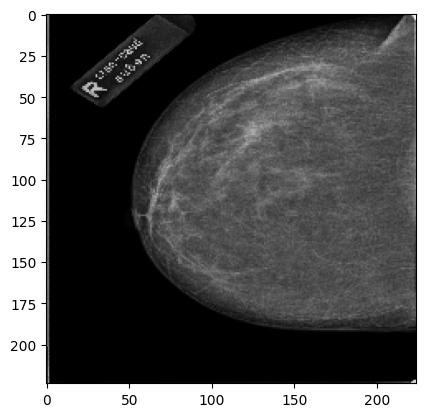

In [15]:
# Display image
image = validation_images[1][0][0]

# Display the normalized image
plt.imshow(image)
plt.show()

# Create ResNet50 Model (GPU)

In [17]:
# Create the neural network model
def convolutional_model(base_model, device):
    with tf.device(device):
        model = Sequential(name='sequential')
        model.add(base_model)
        model.add(Dropout(0.2))
        model.add(Flatten())
        model.add(Dense(256, activation='relu'))
        model.add(Dropout(0.2))
        model.add(BatchNormalization())
        model.add(Dense(256, activation='relu'))
        model.add(Dropout(0.2))
        model.add(BatchNormalization())
        model.add(Dense(256, activation='relu'))
        model.add(Dropout(0.2))
        model.add(BatchNormalization())
        model.add(Dense(2, activation='softmax'))
        
        # Print a summary of the model architecture
        model.summary()

        # Compile the model
        opt = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
        model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])

        return model
    
# Load the ResNet50 model without the fully connected layers
base_model = ResNet50(weights='imagenet', pooling='avg', include_top=False, input_shape=(224, 224, 3))

# Freeze the weights of the base model to avoid training during fine-tuning
base_model.trainable = False

# Create ResNet50 model using AMD GPU
resnet50_model = convolutional_model(base_model, 'DML')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               524544    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dense_5 (Dense)              (None, 256)               6

# Model Callbacks

In [19]:
# Save best model and create early stop
cb_checkpointer = ModelCheckpoint(filepath='./best_not_segmented_2_classes.hdf5', save_weights_only=False, monitor='val_acc', save_best_only=True, mode='max', verbose=1)

# Fit Model

In [20]:
# Fit model with train and validation, and add callbacks
step_size_train = train_images.n//train_images.batch_size
step_size_validation = validation_images.n//validation_images.batch_size

resnet50_model.fit(
    train_images,
    validation_data=validation_images,
    epochs=30,
    callbacks=[cb_checkpointer],
    validation_steps=step_size_validation,
    steps_per_epoch=step_size_train
)
resnet50_model.load_weights("./best_not_segmented_2_classes.hdf5")

Epoch 1/30
29/88 [========>.....................] - ETA: 19s - loss: 0.7327 - acc: 0.5054
Epoch 00001: val_acc improved from -inf to 0.50539, saving model to ./best_not_segmented_2_classes.hdf5
88/88 [==============================] - 41s 466ms/step - loss: 0.5169 - acc: 0.7721 - val_loss: 0.7327 - val_acc: 0.5054
Epoch 2/30
29/88 [========>.....................] - ETA: 16s - loss: 0.7507 - acc: 0.5054
Epoch 00002: val_acc did not improve from 0.50539
88/88 [==============================] - 32s 367ms/step - loss: 0.3708 - acc: 0.8382 - val_loss: 0.7507 - val_acc: 0.5054
Epoch 3/30
29/88 [========>.....................] - ETA: 16s - loss: 0.6981 - acc: 0.5054
Epoch 00003: val_acc did not improve from 0.50539
88/88 [==============================] - 32s 365ms/step - loss: 0.3262 - acc: 0.8579 - val_loss: 0.6981 - val_acc: 0.5054
Epoch 4/30
29/88 [========>.....................] - ETA: 16s - loss: 0.8310 - acc: 0.5054
Epoch 00004: val_acc did not improve from 0.50539
88/88 [=============

# Evaluation Model

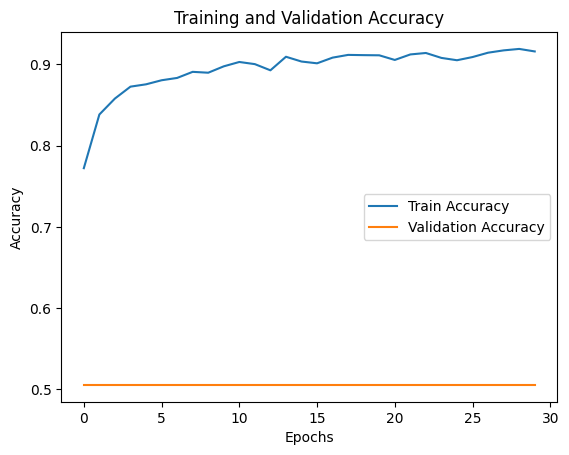

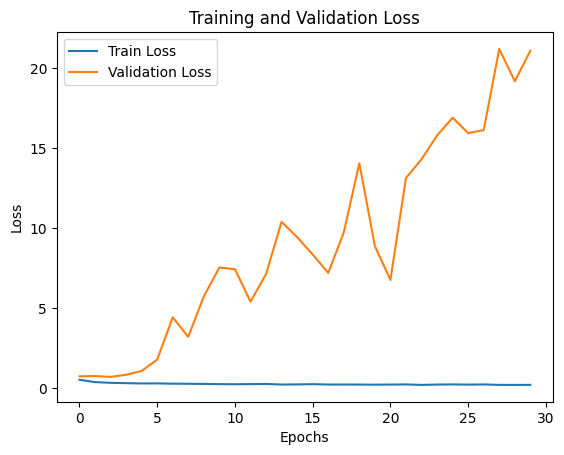

In [21]:
# Obter as métricas de treinamento
train_accuracy = resnet50_model.history.history['acc']
train_loss = resnet50_model.history.history['loss']

# Obter as métricas de validação
val_accuracy = resnet50_model.history.history['val_acc']
val_loss = resnet50_model.history.history['val_loss']

# Criar gráfico da acurácia
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Criar gráfico da perda
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


In [22]:
# Calcular as métricas nos dados de validatione (mesmo que o gerador de validação)
validation_results = resnet50_model.evaluate_generator(test_images, steps=1)

# Extrair as métricas
validation_loss = validation_results[0]
validation_accuracy = validation_results[1]

# Imprimir as métricas
print(f'Validation Loss: {round(validation_loss, 2)}')
print(f'Validation Accuracy: {round(validation_accuracy * 100, 2)}%')

Validation Loss: 0.66
Validation Accuracy: 62.5%


In [24]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Definir o número total de amostras no conjunto de teste
num_samples = len(test_images.filenames)

# Fazer as previsões com o modelo usando o gerador
predictions = resnet50_model.predict_generator(test_images, steps=num_samples // test_images.batch_size)

# Converter as previsões em rótulos de classe
predicted_labels = np.argmax(predictions, axis=1)

# Obter os rótulos verdadeiros do gerador
true_labels = test_images.classes

# Calcular a acurácia usando o método evaluate_generator
_, accuracy = resnet50_model.evaluate_generator(test_images, steps=num_samples // test_images.batch_size)

# Calcular a precisão
precision = precision_score(true_labels, predicted_labels, average='weighted')

# Calcular a sensibilidade (recall)
recall = recall_score(true_labels, predicted_labels, average='weighted')

# Calcular o F1-score
f1 = f1_score(true_labels, predicted_labels, average='weighted')

# Calcular a matriz de confusão
confusion_mat = confusion_matrix(true_labels, predicted_labels)

# Calcular a especificidade
num_classes = confusion_mat.shape[0]
specificity = []

for i in range(num_classes):
    tn = np.sum(np.delete(np.delete(confusion_mat, i, axis=0), i, axis=1))
    fp = np.sum(np.delete(confusion_mat, i, axis=0)[:, i])
    specificity.append(tn / (tn + fp))

# Calcular a média da especificidade
average_specificity = np.mean(specificity)

# Imprimir as métricas
print(f"Accuracy: {round(accuracy * 100, 2)}%")
print(f"Precision: {round(precision * 100, 2)}%")
print(f"Recall (Sensibility): {round(recall * 100, 2)}%")
print(f"Mean Specificity: {round(average_specificity * 100, 2)}%")
print(f"F1-Score: {round(f1 * 100, 2)}%")

Accuracy: 50.0%
Precision: 25.0%
Recall (Sensibility): 50.0%
Mean Specificity: 50.0%
F1-Score: 33.33%


c:\Users\criss\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
from sklearn.metrics import confusion_matrix

# Prever as classes para o conjunto de testes
y_pred = resnet50_model.predict(test_images)
y_pred = np.argmax(y_pred, axis=1)

# Converter as classes verdadeiras em um array unidimensional
y_true = test_images.classes

# Calcular a matriz de confusão
confusion_mat = confusion_matrix(y_true, y_pred)

# Imprimir a matriz de confusão
print("Confusion Matrix:")
print(confusion_mat)

Confusion Matrix:
[[624   0]
 [624   0]]


In [26]:
from sklearn.metrics import confusion_matrix, classification_report

# Prever as classes para o conjunto de testes
y_pred = resnet50_model.predict(test_images)
y_pred = np.argmax(y_pred, axis=1)

# Converter as classes verdadeiras em um array unidimensional
y_true = test_images.classes

# Calcular a matriz de confusão
confusion_mat = confusion_matrix(y_true, y_pred)

report = classification_report(test_images.labels, y_pred, target_names=['I', 'III'], digits=4)
print(report)

              precision    recall  f1-score   support

           I     0.5000    1.0000    0.6667       624
         III     0.0000    0.0000    0.0000       624

    accuracy                         0.5000      1248
   macro avg     0.2500    0.5000    0.3333      1248
weighted avg     0.2500    0.5000    0.3333      1248



c:\Users\criss\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\criss\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\criss\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

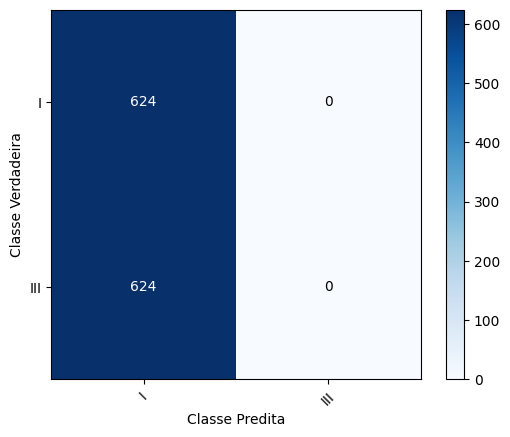

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Fazer as previsões com o modelo
y_pred = resnet50_model.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)

# Converter as classes verdadeiras em um array unidimensional
y_true = test_images.classes

# Calcular a matriz de confusão
cm = confusion_matrix(y_true, y_pred_classes)

# Definir as classes
classes = ['I', 'III']

# Plotar a matriz de confusão
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()

# Definir os rótulos dos eixos
plt.xlabel('Classe Predita')
plt.ylabel('Classe Verdadeira')

# Definir os rótulos das classes
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Preencher a matriz com os valores
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

# Mostrar a matriz de confusão
plt.show()

# Testar o Modelo para 1 imagem

In [23]:
# Carregar a imagem
image_path = 'images_train_segmented_increased\IV\g_right_mlo (1).png'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Converter o padrão de cores para RGB
image = cv2.resize(image, (224, 224))  # Redimensionar a imagem para o tamanho esperado pelo modelo (224x224)
image = np.expand_dims(image, axis=0)  # Adicionar uma dimensão extra para representar o batch de imagens

# Pré-processar a imagem
image = preprocess_input(image)

# Predicao
predictions = resnet50_model.predict(image)

# Interpretar as previsões
class_names = ['I', 'II', 'III', 'IV']
predicted_class = np.argmax(predictions[0])
predicted_label = class_names[predicted_class]

# Calcular a precisão da previsão
accuracy = predictions[0][predicted_class]

print('Previsão:', predicted_label)
print('Precisão:', accuracy)

Previsão: II
Precisão: 0.6625094
